<a href="https://colab.research.google.com/github/AverYuchen/DeepLearning/blob/main/DeepConvolutionGANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3: Generative Adversarial Networks (GANs)

Reference Paper: [UNSUPERVISED REPRESENTATION LEARNING WITH DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL NETWORKS](https://arxiv.org/pdf/1511.06434.pdf)

A Generative Adversarial Network (GAN) is a neural network model consisting of two modules, termed the generator $G$ and the discriminator $D$. A GAN is trained using two steps of backpropagation. Step 1: updating the weights of the Discriminator $D$, and step 2: updating the weights of the Generator $G$.


![](https://drive.google.com/uc?export=view&id=1Q4sz0dHkr1v2cm3wdKDEWoHkl9PkBdYx)

**Step 1: Updating the weights of $D$**

We feed the discriminator $D$ some real images ($\mathbf{x}_{\text{real}}$) and see what it misclassifies using [Binary Cross Entropy Loss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html):

$$\text{loss}_{\text{real}} = \text{BCELoss}\left(D(\mathbf{x}_{\text{real}}), \mathbf{1}\right)$$

where the loss is computed against $\mathbf{1}$ (a vector of $1$'s) because the label for all real images is $1$.

We do the same thing with fake images, except that the loss is now computed against $\mathbf{0}$ (a vector of $0$'s) because the label for all fake images is $0$:

$$\text{loss}_{\text{fake}} = \text{BCELoss}\left(D(\mathbf{x}_{\text{fake}}), \mathbf{0}\right)$$

where $\mathbf{x}_{\text{fake}} = G(\mathbf{z})$, with $\mathbf{z}$ being random noise. That is, the fake images are the outputs of the generator $G$, which has been fed random noise as input. We could therefore write:

$$\text{loss}_{\text{fake}} = \text{BCELoss}\left(D(G(\mathbf{z})), \mathbf{0}\right)$$

Importantly, backpropagation ***is not applied*** to the generator $G$ during this phase, and gradients computed do not take the processes of the generator $G$ into account.

In PyTorch, this is achieved by calling [`.detach()`](https://pytorch.org/docs/stable/generated/torch.Tensor.detach.html) on $\mathbf{x}_{\text{fake}}$. This is done because we want to train the generator $G$ to ***fool*** the discriminator $D$, rather than agree with it. We optimize only the parameters of the discriminator $D$ in this phase. We can also define the total loss as follows:

$$\text{loss}_{\text{disc}} = \text{loss}_{\text{real}} + \text{loss}_{\text{fake}}$$

The right side of the image can be interpreted as follows.

We feed fake images into the discriminator $D$ as before:

$$\text{loss}_{\text{gen}} = \text{BCELoss}\left(D(\mathbf{x}_{\text{fake}}), \mathbf{0}\right)$$

Importantly, backpropagation ***is applied*** to the generator $G$ during this phase (we simply do not call `.detach()` here). This is done because we are now training the generator $G$.

We also need to ***flip the sign*** of the gradients before updating the generator $G$, because we again want to ***fool*** the discriminator, rather than produce things it can learn. That is, we need to optimize the generator $G$ so as to cause the discriminator $D$ to make more mistakes. We optimize only the parameters of the generator $G$ in this phase.

**Step 2: Updating the weights of $G$**

One way to update the weights of $G$ is to flip the gradients (*-1) resulting from backpropagating through the discriminator and backpropagate through the generator, as depicted in the right side of the above figure.

**Another way, that is easier to implement in PyTorch, that we will implement in this assignment, is explained below:**

Rather than flipping the sign of the gradients, we simply compute

$$\text{loss}_{\text{gen}} = \text{BCELoss}\left(D(\mathbf{x}_{\text{fake}}), \mathbf{1}\right)$$

Importantly, we are computing the loss against $\mathbf{1}$ ***rather than*** $\mathbf{0}$.

It is worth thinking for a moment about why this works. We are asking the discriminator $D$ whether the images are real or fake, but of course all the images $\mathbf{x}_{\text{fake}} = G(\mathbf{z})$ are fake. If the discriminator $D$ were perfect, it would predict $0$ (fake) for everything.

This is precisely the opposite of what we want for the generator $G$, because it means the generator $G$ is not fooling the discriminator $D$ at all, and so the loss will be large in this situation.

Conversely, if the discriminator $D$ predicts $1$ for everything, we don't need to update the generator $G$ at all, because it has fooled the discriminator $D$ into classifying all the fake images as real.

This is the implementation we will use.

## Imports and Data

Imports, including `numpy` and `matplotlib.pyplot` for displaying images.

In [2]:
import argparse
import os
import math

import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision.datasets import MNIST, CelebA
import torchvision.utils as vutils

from torch import nn
import torch.nn.functional as F
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Let's load and transform the [MNIST dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html) and wrap it in a [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader). We'll also apply a [transform](https://pytorch.org/vision/0.11/transforms.html):
- [torchvision.transforms.ToTensor](https://pytorch.org/vision/0.11/transforms.html#torchvision.transforms.ToTensor)
- [torchvision.transforms.Resize](https://pytorch.org/vision/0.11/transforms.html#torchvision.transforms.Resize)
- [torchvision.transforms.Normalize](https://pytorch.org/vision/0.11/transforms.html#torchvision.transforms.Normalize)

In [3]:
img_size = 28
traindataset = MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize([img_size, img_size]),
        transforms.Normalize((0.5,), (0.5,))
    ])
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 426kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.91MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.62MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
batch_size = 64
trainloader = DataLoader(
    traindataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    drop_last=True,
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Defining a Generator and a Discriminator

In [5]:
latent_dim = 100
channels = 1

Let's define the generator $G$. Some useful documentation:
- [torch.nn.ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) - we are upsampling from a lower dimensionality to a higher one.
- [torch.nn.BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)
- [torch.nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
- [torch.nn.Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html)

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        output = self.main(input)
        return output


Let's also define the discriminator $D$. Some useful documentation:
- [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- [torch.nn.BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)
- [torch.nn.LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html)
- [torch.nn.Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1)

We'll use a [torch.nn.init.normal_](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.normal_) initialization for most weights, but we'll initialize bias terms to be 0 (a common practice) with [torch.nn.init.constant_](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.constant_):

In [8]:
def weights_init(m):
    class_name = m.__class__.__name__
    if 'Conv' in class_name: # conv weights near 0
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif 'BatchNorm' in class_name: # norm weights near 1
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

We can now initialize both components of the GAN, and apply our custom weight initialization:

In [9]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

Now we'll define the loss function ([torch.nn.BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)) and the optimizer ([torch.optim.Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)).

In [10]:
adversarial_loss = torch.nn.BCELoss()

optim_gen = torch.optim.Adam(
    generator.parameters(),
    lr=0.0002,
    betas = (0.5, 0.999)
)
optim_disc = torch.optim.Adam(
    discriminator.parameters(),
    lr=0.0002,
    betas = (0.5, 0.999)
)

In [11]:
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bias=False)
    (13): Tanh()
  )
)


In [12]:
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


## Training the Generator and Discriminator together

**Q1. [40 points]** Complete the `train_mnist` function to include training of the Discriminator (20 points) and the Generator (20 points).

In [17]:
# torch.manual_seed(42) # seeds random number generation for reproducibility
fixed_noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
num_epochs = 5

img_list = []

def train_mnist():
    iters = 0 # total number of batches seen by the models
    for epoch in range(num_epochs):

        # ensure training mode
        discriminator.train()
        generator.train()

        for idx, (imgs, _) in enumerate(trainloader):

            # adversarial ground truths
            # 0 = fake, 1 = real
            real_labels = torch.full(
                [imgs.size(0), 1], # vector of size batch_size X 1
                1.0,               # filled with 1's
                dtype=imgs.dtype   # ensure float32
            ).to(device)

            fake_labels = torch.full(
                [imgs.size(0), 1], # vector of size batch_size X 1
                0.0,               # filled with 0's
                dtype=imgs.dtype   # ensure float32
            ).to(device)

            # ---- TODO 1a) ----
            """TRAIN DISCRIMINATOR"""
            optim_disc.zero_grad()
            real_imgs = imgs.to(device)
            output_real = discriminator(real_imgs)
            loss_real = adversarial_loss(output_real, real_labels)
            loss_real.backward()

            noise = torch.randn(imgs.size(0), latent_dim, 1, 1, device=device)
            fake_imgs = generator(noise)
            output_fake = discriminator(fake_imgs.detach())
            loss_fake = adversarial_loss(output_fake, fake_labels)
            loss_fake.backward()

            disc_loss = loss_real + loss_fake
            optim_disc.step()

            # ---- TODO 1b) ----
            """TRAIN GENERATOR"""
            optim_gen.zero_grad()
            output = discriminator(fake_imgs)
            gen_loss = adversarial_loss(output, real_labels)
            gen_loss.backward()
            optim_gen.step()

            # logging
            if idx % 50 == 0:
                print(
                    f'[{epoch:4d}/{num_epochs}][{idx:3d}/{len(trainloader)}]\t'
                    f'Loss_Discriminator: {disc_loss.item():.4f}\t'
                    f'Loss_Generator: {gen_loss.item():.4f}'
                )

            # plot the real images and the generations for comparison
            if idx % 100 == 0:
              fake = generator(fixed_noise)
              img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    # Plot the real images
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(imgs.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    # Plot the fake images from the last epoch
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[-1].cpu(),(1,2,0)))
    plt.show()

[   0/5][  0/937]	Loss_Discriminator: 1.7865	Loss_Generator: 1.0252
[   0/5][ 50/937]	Loss_Discriminator: 0.2205	Loss_Generator: 4.1801
[   0/5][100/937]	Loss_Discriminator: 0.4638	Loss_Generator: 3.2445
[   0/5][150/937]	Loss_Discriminator: 0.5354	Loss_Generator: 1.9636
[   0/5][200/937]	Loss_Discriminator: 0.2832	Loss_Generator: 2.7480
[   0/5][250/937]	Loss_Discriminator: 0.2154	Loss_Generator: 3.6915
[   0/5][300/937]	Loss_Discriminator: 0.2912	Loss_Generator: 2.5651
[   0/5][350/937]	Loss_Discriminator: 0.2810	Loss_Generator: 2.1254
[   0/5][400/937]	Loss_Discriminator: 0.2283	Loss_Generator: 2.3801
[   0/5][450/937]	Loss_Discriminator: 0.2934	Loss_Generator: 2.6215
[   0/5][500/937]	Loss_Discriminator: 0.3626	Loss_Generator: 2.3314
[   0/5][550/937]	Loss_Discriminator: 0.7633	Loss_Generator: 2.4077
[   0/5][600/937]	Loss_Discriminator: 0.4403	Loss_Generator: 2.3838
[   0/5][650/937]	Loss_Discriminator: 0.6872	Loss_Generator: 2.5595
[   0/5][700/937]	Loss_Discriminator: 1.6017	Los

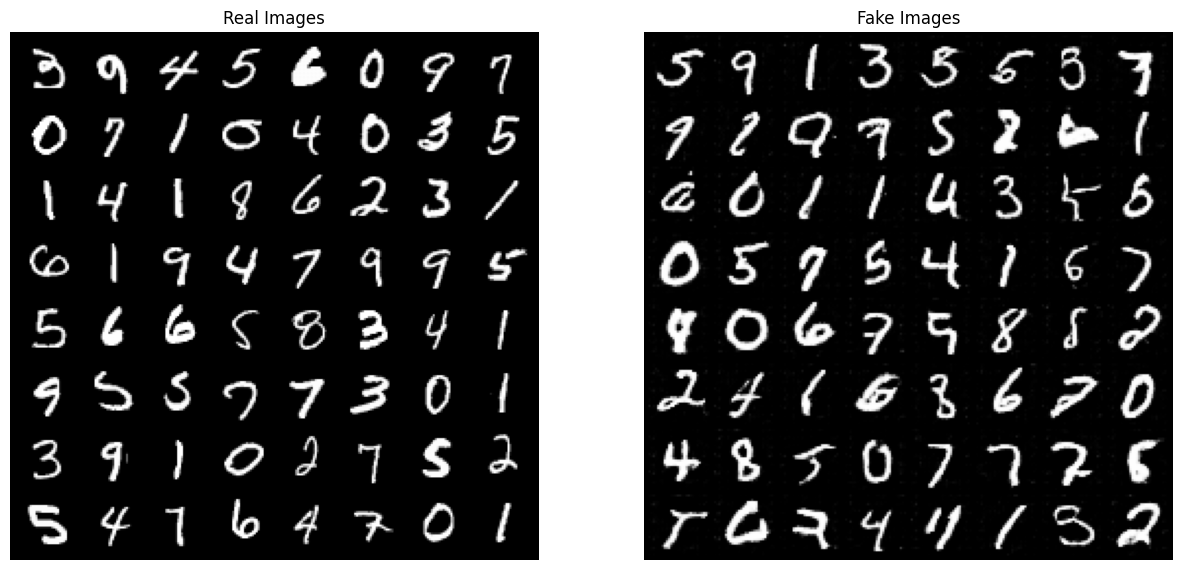

In [18]:
# run the training function for the MNIST data
train_mnist()

**Q2. [4 points]**  For a training dataset D = {$𝑥_{𝑖}, 𝑦_{𝑖}$} where $𝑥_{𝑖}$ are the inputs and $𝑦_{𝑖}$ are the output, explain the difference between discriminative and generative classification models.


---- TODO Q2 ----


Generative classifer "based on 𝑃(𝑥,𝑦)", but discriminative classifier "based on 𝑃(𝑦|𝑥)". Generative models model the distribution of individual classes, while discriminative models learn the hard or soft boundary between classes




**Q3. [6 points]** The following is a figure of a *conditional* GAN. Give one example of a conditional GAN application, explain what it is conditioned on, and how it works. Your answer should be based on a brief survey/research of conditional GANs.

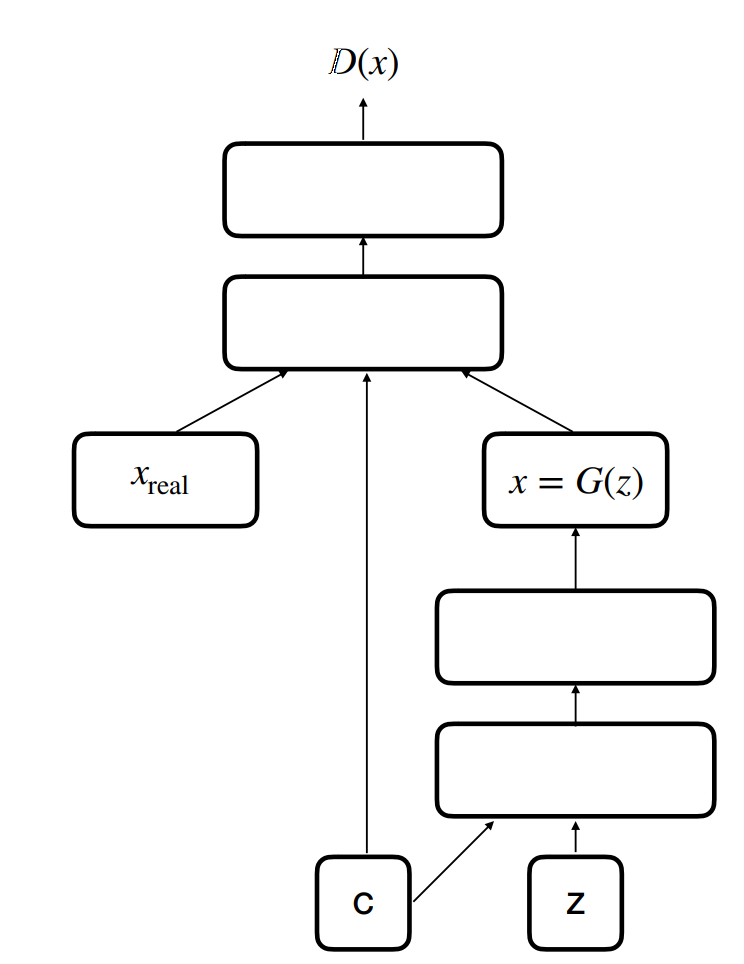


---- TODO Q3 ----

Dall-E is a real life application of conditional GAN. This is developed by OpenAI. It is an application that generate pictures based on the descriptive requests. The conditional GAN is conditioned on text descriptions, which makes the model to generate images that match specific details in the text. The generator uses the text embedding as context to create an image that aligns with the details provided in the text.The discriminator learns to distinguish between real images (matching the text) and fake images (generated ones). The generator receives a random noise vector (as in a standard GAN) and a text embedding derived from the descriptive input text. The discriminator also receives both the generated or real image and the same text embedding, allowing it to assess whether the image realistically matches the description. The generator and discriminator are trained adversarially. The generator improves by minimizing the discriminator’s ability to distinguish between real and generated images, while the discriminator maximizes its accuracy.


## Optional: CelebA Dataset

The [CelebA dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.CelebA.html), introduced in [Liu et al. (2015)](https://arxiv.org/pdf/1411.7766v3.pdf) may also be interesting to generate face images, but bear in mind it will take a lot longer to run. Some code is included below to load and transform it, should you be curious.

In [ ]:
# # load and transform CelebA
# image_size = 64
# celeb_a_dataset = CelebA(
#     root='./data',
#     train=True,
#     download=True,
#     transform=transforms.Compose(
#         [
#           transforms.Resize(image_size),
#           transforms.CenterCrop(image_size),
#           transforms.ToTensor(),
#           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#         ]
#     )
# )

In [ ]:
# # wrap CelebA data in a DataLoader
# batch_size = 64
# trainloader = torch.utils.data.DataLoader(
#     celeb_a_dataset,
#     batch_size=batch_size,
#     shuffle=True,
#     num_workers=workers,
#     drop_last=True
# )